# Lexicon Based


In [1]:
# Load the Data

import pandas as pd


malta_loc_18 = '../data/Malta-Budget-2018-dataset-v1.csv'
malta_loc_19 = '../data/Malta-Budget-2019-dataset-v1.csv'
malta_loc_20 = '../data/Malta-Budget-2020-dataset-v1.csv'

malta_data_18 = pd.read_csv(malta_loc_18)
malta_data_19 = pd.read_csv(malta_loc_19)
malta_data_20 = pd.read_csv(malta_loc_20)

print(malta_data_18.info())
print(malta_data_19.info())
print(malta_data_20.info())

malta_data_19 = malta_data_19.rename(columns={'Off-topic ':'Off-topic'})
combined_data = pd.concat([malta_data_18, malta_data_19, malta_data_20], ignore_index=True)
combined_data.info()

clean_data = combined_data.dropna(subset=['Online Post Text'])
clean_data = clean_data.drop(['Twitter ID', 'Related Online Post ID', 'Source ID','Off-topic'], axis=1)
clean_data = clean_data[clean_data['Language'] == 0] # get all data that is in english 
clean_data = clean_data.drop(['Language'], axis=1)
clean_data = clean_data.rename(columns={'Online Post ID':'ID','Online Post Text':'Text'})


# clean_data = clean_data.drop(['ID','Subjectivity', 'Sentiment Polarity', 'Sarcasm', 'Irony', 'Negation'], axis=1)
clean_data = clean_data.drop(['ID'], axis=1)

clean_data.head()
clean_data.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2142 entries, 0 to 2141
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Online Post ID          2142 non-null   int64  
 1   Twitter ID              1673 non-null   float64
 2   Related Online Post ID  333 non-null    float64
 3   Source ID               2142 non-null   object 
 4   Online Post Text        469 non-null    object 
 5   Subjectivity            2142 non-null   int64  
 6   Sentiment Polarity      2142 non-null   object 
 7   Emotion                 2142 non-null   object 
 8   Sarcasm                 2142 non-null   int64  
 9   Irony                   2142 non-null   int64  
 10  Negation                2142 non-null   int64  
 11  Off-topic               2142 non-null   int64  
 12  Language                2142 non-null   int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 217.7+ KB
None
<class 'pandas.core.frame.Dat

Text  Subjectivity  \
5068  Wow growing together, so I will get a 17 black...             1   
5069  Equal pay for equal work to be introduced in t...             1   
5070  No cash when worth more then 10000?. Use offsh...             1   
5071  Budget 2020 reactions: Some say it’s good, oth...             1   
5072  Budget 2020 reactions: Some say it’s good, oth...             1   

     Sentiment Polarity       Emotion  Sarcasm  Irony  Negation  
5068           positive       disgust        0      1         0  
5069           positive  anticipation        0      0         1  
5070           negative  anticipation        0      1         0  
5071           negative         anger        0      0         0  
5072            neutral       sadness        0      0         0

In [2]:
# Handle text processing and tokenisation:

import string
import re
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions
from transformers import BertTokenizer

processed_data = clean_data.copy(deep=True)

def remove_special_characters(text):
    pattern = re.compile(r'[^a-zA-Z\s]')
    return pattern.sub('', text)

# Remove URLs and HTML tags
processed_data['Raw_Text'] = processed_data['Text']

processed_data['Text'] = processed_data['Text'].str.replace(r'http\S+|www\S+|https\S+', '', regex=True)
processed_data['Text'] = processed_data['Text'].str.replace(r'<.*?>', '', regex=True)

# Expand contractions
processed_data['Text'] = processed_data['Text'].apply(lambda x: contractions.fix(x))

# Convert to lowercase
processed_data['Text'] = processed_data['Text'].str.lower()

# Remove punctuation
processed_data['Text'] = processed_data['Text'].str.replace(f"[{string.punctuation}]", " ", regex=True)

# Remove numbers
processed_data['Text'] = processed_data['Text'].str.replace(r'\d+', '', regex=True)

# Remove special characters
processed_data['Text'] = processed_data['Text'].apply(remove_special_characters)

# Remove stop words
stop_words = set(stopwords.words('english'))
processed_data['Text'] = processed_data['Text'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

# Remove extra whitespace
processed_data['Text'] = processed_data['Text'].str.strip()
processed_data['Text'] = processed_data['Text'].str.replace(r'\s+', ' ', regex=True)

# Lemmatize
lemmatizer = WordNetLemmatizer()
processed_data['Text'] = processed_data['Text'].apply(lambda x: ' '.join(lemmatizer.lemmatize(word) for word in x.split()))

# Tokenize
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') #30522 
tokenizer_features = 30522
processed_data['tokens'] = processed_data['Text'].apply(lambda x: tokenizer.tokenize(x)) 

max_words = processed_data['Text'].apply(lambda x: len(x.split())).max()

max_tokens = processed_data['tokens'].apply(lambda x: len(x)).max()

def encode_texts(texts, tokenizer, max_len): 
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            truncation=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    return input_ids, attention_masks

processed_data['padded'], processed_data['masks'] = encode_texts(processed_data['Text'].tolist(), tokenizer, 100)

processed_data.head()

[nltk_data] Downloading package wordnet to /Users/alex/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Text  Subjectivity  \
0  great budget even cigarette touched great work...             1   
1  exactly scanned budget throughout earth make i...             1   
2  already smoking cessation program people want ...             1   
3  alcohol fuel private vehicle raising tax cigar...             1   
4  practical say third world country supposed eur...             1   

  Sentiment Polarity       Emotion  Sarcasm  Irony  Negation  \
0           positive         trust        0      0         1   
1           negative       disgust        0      0         1   
2            neutral  anticipation        0      0         0   
3           negative       sadness        0      0         0   
4           negative         anger        0      0         1   

                                            Raw_Text  \
0  Great BUDGET . Even cigarettes were not touche...   
1  I haven't exactly scanned the budget throughou...   
2  There’s already smoking cessation programs for...   
3  So should alcohol and fuel for private vehicle...   
4  Practical? You should say that in a third worl...   

                                              tokens  \
0  [great, budget, even, cigarette, touched, grea...   
1  [exactly, scanned, budget, throughout, earth, ...   
2  [already, smoking, ce, ##ssa, ##tion, program,...   
3  [alcohol, fuel, private, vehicle, raising, tax...   
4  [practical, say, third, world, country, suppos...   

                                              padded  \
0  [101, 2307, 5166, 2130, 9907, 5028, 2307, 2147...   
1  [101, 3599, 11728, 5166, 2802, 3011, 2191, 166...   
2  [101, 2525, 9422, 8292, 11488, 3508, 2565, 211...   
3  [101, 6544, 4762, 2797, 4316, 6274, 4171, 9907...   
4  [101, 6742, 2360, 2353, 2088, 2406, 4011, 2647...   

                                               masks  
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...

In [3]:
# Count Punctuation

import re
import pandas as pd

def count_punctuation(text):
    exclamation_count = len(re.findall(r'!', text))
    question_count = len(re.findall(r'\?', text))
    ellipsis_count = len(re.findall(r'\.\.\.', text))
    comma_count = len(re.findall(r',', text))
    period_count = len(re.findall(r'\. ', text))
    return pd.Series({
        'exclamation_count': exclamation_count,
        'question_count': question_count,
        'ellipsis_count': ellipsis_count,
        'comma_count': comma_count,
        'period_count': period_count
    })
    
processed_data = processed_data.join(processed_data['Raw_Text'].apply(count_punctuation))
print(processed_data)

                                                   Text  Subjectivity  \
0     great budget even cigarette touched great work...             1   
1     exactly scanned budget throughout earth make i...             1   
2     already smoking cessation program people want ...             1   
3     alcohol fuel private vehicle raising tax cigar...             1   
4     practical say third world country supposed eur...             1   
...                                                 ...           ...   
5068              wow growing together get black budget             1   
5069  equal pay equal work introduced private sector...             1   
5070                    cash worth use offshore account             1   
5071  budget reaction say good others say bad earnes...             1   
5072  budget reaction say good others say bad happen...             1   

     Sentiment Polarity       Emotion  Sarcasm  Irony  Negation  \
0              positive         trust        0      0   

In [4]:
# Emotion counts 

# Load NRC lexicon
nrc_lexicon_path = '../Lexicons/NRC/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'
nrc_emotion_lexicon = pd.read_csv(nrc_lexicon_path, sep='\t', header=None, names=['word', 'emotion', 'association'])

# Filter emotions of interest
emotions_of_interest = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
nrc_emotion_lexicon = nrc_emotion_lexicon[nrc_emotion_lexicon['emotion'].isin(emotions_of_interest) & nrc_emotion_lexicon['association'] == 1]

# Convert the lexicon to a dictionary for faster lookup
emotion_dict = {}
for i, row in nrc_emotion_lexicon.iterrows():
    if i < 100 :
        print(row)
    word = row['word']
    emotion = row['emotion']
    if word in emotion_dict:
        emotion_dict[word].append(emotion)
    else:
        emotion_dict[word] = [emotion]
print(emotion_dict)
        
def detect_emotions(tokens):
    emotions_count = {emotion: 0 for emotion in emotions_of_interest}
    
    for token in tokens:
        if token in emotion_dict:
            for emotion in emotion_dict[token]:
                emotions_count[emotion] += 1
                
    return pd.Series(emotions_count)
    
processed_data = processed_data.join(processed_data['tokens'].apply(detect_emotions))

processed_data.rename(columns={col: f'{col}_count' for col in processed_data.columns if col in emotions_of_interest}, inplace=True)
 
print(processed_data)

word           abacus
emotion         trust
association         1
Name: 19, dtype: object
word           abandon
emotion           fear
association          1
Name: 23, dtype: object
word           abandon
emotion        sadness
association          1
Name: 27, dtype: object
word           abandoned
emotion            anger
association            1
Name: 30, dtype: object
word           abandoned
emotion             fear
association            1
Name: 33, dtype: object
word           abandoned
emotion          sadness
association            1
Name: 37, dtype: object
word           abandonment
emotion              anger
association              1
Name: 40, dtype: object
word           abandonment
emotion               fear
association              1
Name: 43, dtype: object
word           abandonment
emotion            sadness
association              1
Name: 47, dtype: object
word           abandonment
emotion           surprise
association              1
Name: 48, dtype: object
word   

In [5]:
# Polarity 

nrc_lexicon = pd.read_csv(nrc_lexicon_path, sep='\t', header=None, names=['word', 'emotion', 'association'])

# Get pos and neg words
positive_words = nrc_lexicon[(nrc_lexicon['emotion'] == 'positive') & (nrc_lexicon['association'] == 1)]['word'].tolist()
negative_words = nrc_lexicon[(nrc_lexicon['emotion'] == 'negative') & (nrc_lexicon['association'] == 1)]['word'].tolist()

def count_polarity_words(tokens, positive_words, negative_words):
    pos_count = 0
    neg_count = 0
    for token in tokens:
        if token in positive_words:
            pos_count +=1 
        if token in negative_words:
            neg_count +=1
            
    return pos_count, neg_count

# processed_data[['pos_count', 'neg_count']] = processed_data['tokens'].apply(lambda tokens: count_polarity_words(tokens, positive_words, negative_words))

processed_data[['pos_count', 'neg_count']] = processed_data['tokens'].apply(
    lambda x: pd.Series(count_polarity_words(x, positive_words, negative_words))
    )

print(processed_data)

                                                   Text  Subjectivity  \
0     great budget even cigarette touched great work...             1   
1     exactly scanned budget throughout earth make i...             1   
2     already smoking cessation program people want ...             1   
3     alcohol fuel private vehicle raising tax cigar...             1   
4     practical say third world country supposed eur...             1   
...                                                 ...           ...   
5068              wow growing together get black budget             1   
5069  equal pay equal work introduced private sector...             1   
5070                    cash worth use offshore account             1   
5071  budget reaction say good others say bad earnes...             1   
5072  budget reaction say good others say bad happen...             1   

     Sentiment Polarity       Emotion  Sarcasm  Irony  Negation  \
0              positive         trust        0      0   

In [6]:
from afinn import Afinn

afinn = Afinn()
processed_data['afinn_score'] = processed_data['Raw_Text'].apply(lambda x: afinn.score(x))

print(processed_data)


                                                   Text  Subjectivity  \
0     great budget even cigarette touched great work...             1   
1     exactly scanned budget throughout earth make i...             1   
2     already smoking cessation program people want ...             1   
3     alcohol fuel private vehicle raising tax cigar...             1   
4     practical say third world country supposed eur...             1   
...                                                 ...           ...   
5068              wow growing together get black budget             1   
5069  equal pay equal work introduced private sector...             1   
5070                    cash worth use offshore account             1   
5071  budget reaction say good others say bad earnes...             1   
5072  budget reaction say good others say bad happen...             1   

     Sentiment Polarity       Emotion  Sarcasm  Irony  Negation  \
0              positive         trust        0      0   

In [7]:
#objectivity scores 
nltk.download('sentiwordnet')
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn

def get_sentiwordnet_scores(tokens):
    score = 0
    for token in tokens:
        synsets = wn.synsets(token)
        if not synsets:
            continue  # No synset found for the word

        synset = synsets[0]  # Take the first synset
        swn_synset = swn.senti_synset(synset.name())
        score += swn_synset.obj_score()
    if len(tokens) == 0: ## if there are no tokens, then assume objective
        return 1.0
    return score / len(tokens)

# Example

processed_data['obj_score'] = processed_data['tokens'].apply(lambda tokens: get_sentiwordnet_scores(tokens)) 

# pos_score, neg_score, obj_score = get_sentiwordnet_scores(word)
print(processed_data)

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/alex/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


                                                   Text  Subjectivity  \
0     great budget even cigarette touched great work...             1   
1     exactly scanned budget throughout earth make i...             1   
2     already smoking cessation program people want ...             1   
3     alcohol fuel private vehicle raising tax cigar...             1   
4     practical say third world country supposed eur...             1   
...                                                 ...           ...   
5068              wow growing together get black budget             1   
5069  equal pay equal work introduced private sector...             1   
5070                    cash worth use offshore account             1   
5071  budget reaction say good others say bad earnes...             1   
5072  budget reaction say good others say bad happen...             1   

     Sentiment Polarity       Emotion  Sarcasm  Irony  Negation  \
0              positive         trust        0      0   

In [8]:
count_columns = [col for col in processed_data.columns if col.endswith('_count')]

# Step 2: Calculate normalized score and create new columns
for col in count_columns:
    score_col = col.replace('_count', '_score')  # Create the new column name with '_score'

    processed_data[score_col] = processed_data[col] / processed_data['tokens'].apply(len)

# Now 'df' will have the new columns with '_score' suffix
print(processed_data.head())
print(processed_data.columns)

                                                Text  Subjectivity  \
0  great budget even cigarette touched great work...             1   
1  exactly scanned budget throughout earth make i...             1   
2  already smoking cessation program people want ...             1   
3  alcohol fuel private vehicle raising tax cigar...             1   
4  practical say third world country supposed eur...             1   

  Sentiment Polarity       Emotion  Sarcasm  Irony  Negation  \
0           positive         trust        0      0         1   
1           negative       disgust        0      0         1   
2            neutral  anticipation        0      0         0   
3           negative       sadness        0      0         0   
4           negative         anger        0      0         1   

                                            Raw_Text  \
0  Great BUDGET . Even cigarettes were not touche...   
1  I haven't exactly scanned the budget throughou...   
2  There’s already smoking

In [9]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def extract_vader_features(text):
    sentiment = sia.polarity_scores(text)
    return pd.Series({
        'vader_neg': sentiment['neg'],
        'vader_neu': sentiment['neu'],
        'vader_pos': sentiment['pos'],
        'vader_compound': sentiment['compound']
    })

# Apply the function to your DataFrame
vader_features = processed_data['Raw_Text'].apply(extract_vader_features)

# Concatenate the new VADER features with the original DataFrame
processed_data = pd.concat([processed_data, vader_features], axis=1)

# Display the updated DataFrame
print(processed_data.head())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/alex/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                                Text  Subjectivity  \
0  great budget even cigarette touched great work...             1   
1  exactly scanned budget throughout earth make i...             1   
2  already smoking cessation program people want ...             1   
3  alcohol fuel private vehicle raising tax cigar...             1   
4  practical say third world country supposed eur...             1   

  Sentiment Polarity       Emotion  Sarcasm  Irony  Negation  \
0           positive         trust        0      0         1   
1           negative       disgust        0      0         1   
2            neutral  anticipation        0      0         0   
3           negative       sadness        0      0         0   
4           negative         anger        0      0         1   

                                            Raw_Text  \
0  Great BUDGET . Even cigarettes were not touche...   
1  I haven't exactly scanned the budget throughou...   
2  There’s already smoking

# Feature Selection 

In [10]:
clean_data = processed_data.dropna()

to_keep = [
    'afinn_score', 'obj_score', 'exclamation_score', 'question_score', 'ellipsis_score', 'comma_score',
    'period_score', 'anger_score', 'anticipation_score', 'disgust_score', 'fear_score', 'joy_score',
    'sadness_score', 'surprise_score', 'trust_score', 'pos_score', 'neg_score',
    'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound'
]
fuzzy_data = clean_data[to_keep]
mapping_dict = {value: index for index, value in enumerate(clean_data['Emotion'].unique())}
fuzzy_data['Target'] = clean_data['Emotion'].map(mapping_dict)

fuzzy_data.to_csv('fuzzy_data.csv', index=False)

# X = fuzzy_data.values    
# Y = processed_data['Emotion'].values

corr_matrix = fuzzy_data.corr()

print(corr_matrix)

                    afinn_score  obj_score  exclamation_score  question_score  \
afinn_score            1.000000   0.092034          -0.034205       -0.013616   
obj_score              0.092034   1.000000           0.032865        0.119055   
exclamation_score     -0.034205   0.032865           1.000000       -0.015281   
question_score        -0.013616   0.119055          -0.015281        1.000000   
ellipsis_score        -0.039869   0.024771          -0.028720        0.037797   
comma_score            0.055033   0.048386          -0.037015        0.004082   
period_score           0.053783   0.005896          -0.100540       -0.070533   
anger_score           -0.160659  -0.085638           0.014201        0.035519   
anticipation_score     0.146177   0.002530           0.183197       -0.047582   
disgust_score         -0.169016  -0.005525           0.025027       -0.029887   
fear_score            -0.198638   0.003087          -0.018679       -0.048008   
joy_score              0.184

/var/folders/lx/s6mpvqt1305650xxj6d7yfj80000gn/T/ipykernel_43229/3052618140.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fuzzy_data['Target'] = clean_data['Emotion'].map(mapping_dict)


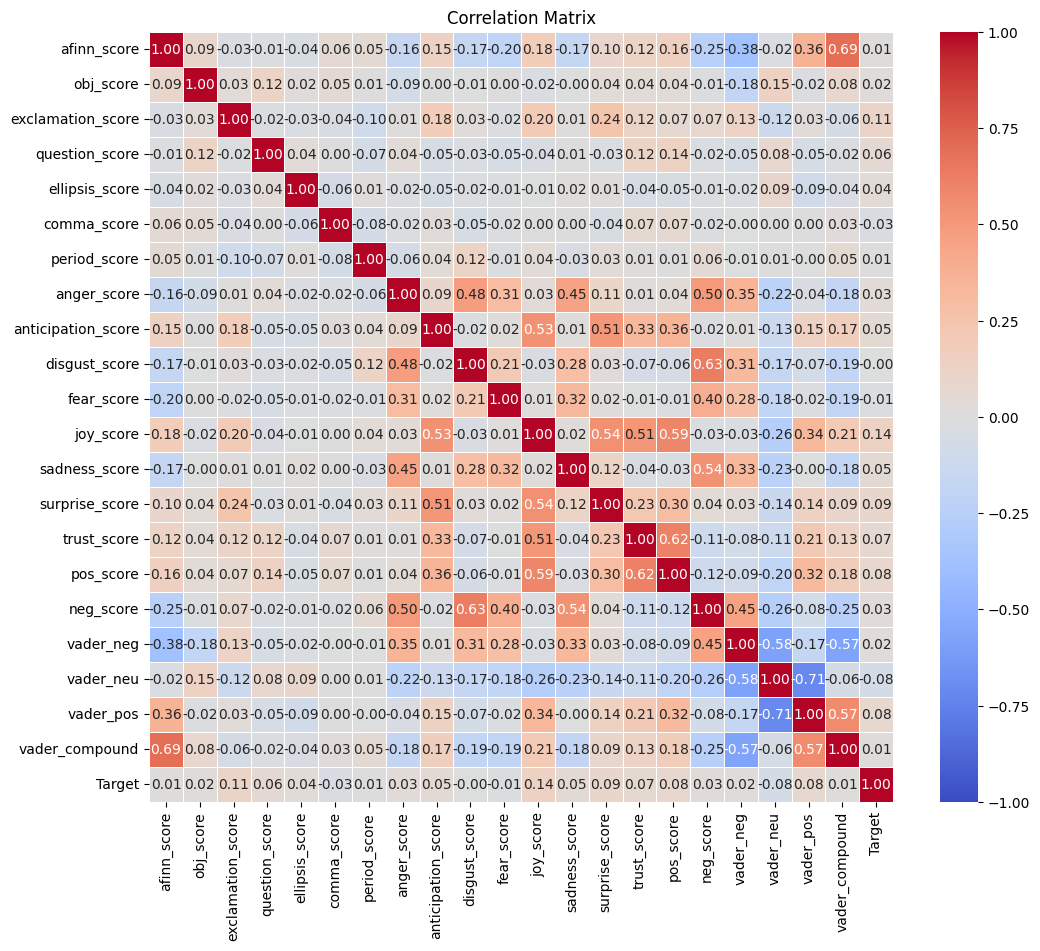

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

In [12]:
print(fuzzy_data.columns)

Index(['afinn_score', 'obj_score', 'exclamation_score', 'question_score',
       'ellipsis_score', 'comma_score', 'period_score', 'anger_score',
       'anticipation_score', 'disgust_score', 'fear_score', 'joy_score',
       'sadness_score', 'surprise_score', 'trust_score', 'pos_score',
       'neg_score', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'Target'],
      dtype='object')


In [13]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

X = fuzzy_data.drop(columns=['Target'])  # Replace 'Target' with your actual target column name
y = fuzzy_data['Target']

# Use an SVM classifier with a linear kernel (or any other estimator of your choice)
model = SVC(kernel='linear')

# Create the RFE object, specifying the estimator and the number of features to select
rfe = RFE(estimator=model, n_features_to_select=5)  # Adjust the number as needed

# Fit the RFE model on the data
rfe.fit(X, y)

# Get the ranking of the features, lower values indicate more important features
ranking = rfe.ranking_

# Create a DataFrame to easily view the results
rfe_df = pd.DataFrame({
    'Feature': X.columns,
    'Ranking': ranking
}).sort_values(by='Ranking')

print(rfe_df)

               Feature  Ranking
2    exclamation_score        1
3       question_score        1
18           vader_neu        1
17           vader_neg        1
19           vader_pos        1
1            obj_score        2
11           joy_score        3
9        disgust_score        4
4       ellipsis_score        5
12       sadness_score        6
14         trust_score        7
5          comma_score        8
16           neg_score        9
13      surprise_score       10
8   anticipation_score       11
20      vader_compound       12
10          fear_score       13
15           pos_score       14
7          anger_score       15
6         period_score       16
0          afinn_score       17


# Feature distribution graphs

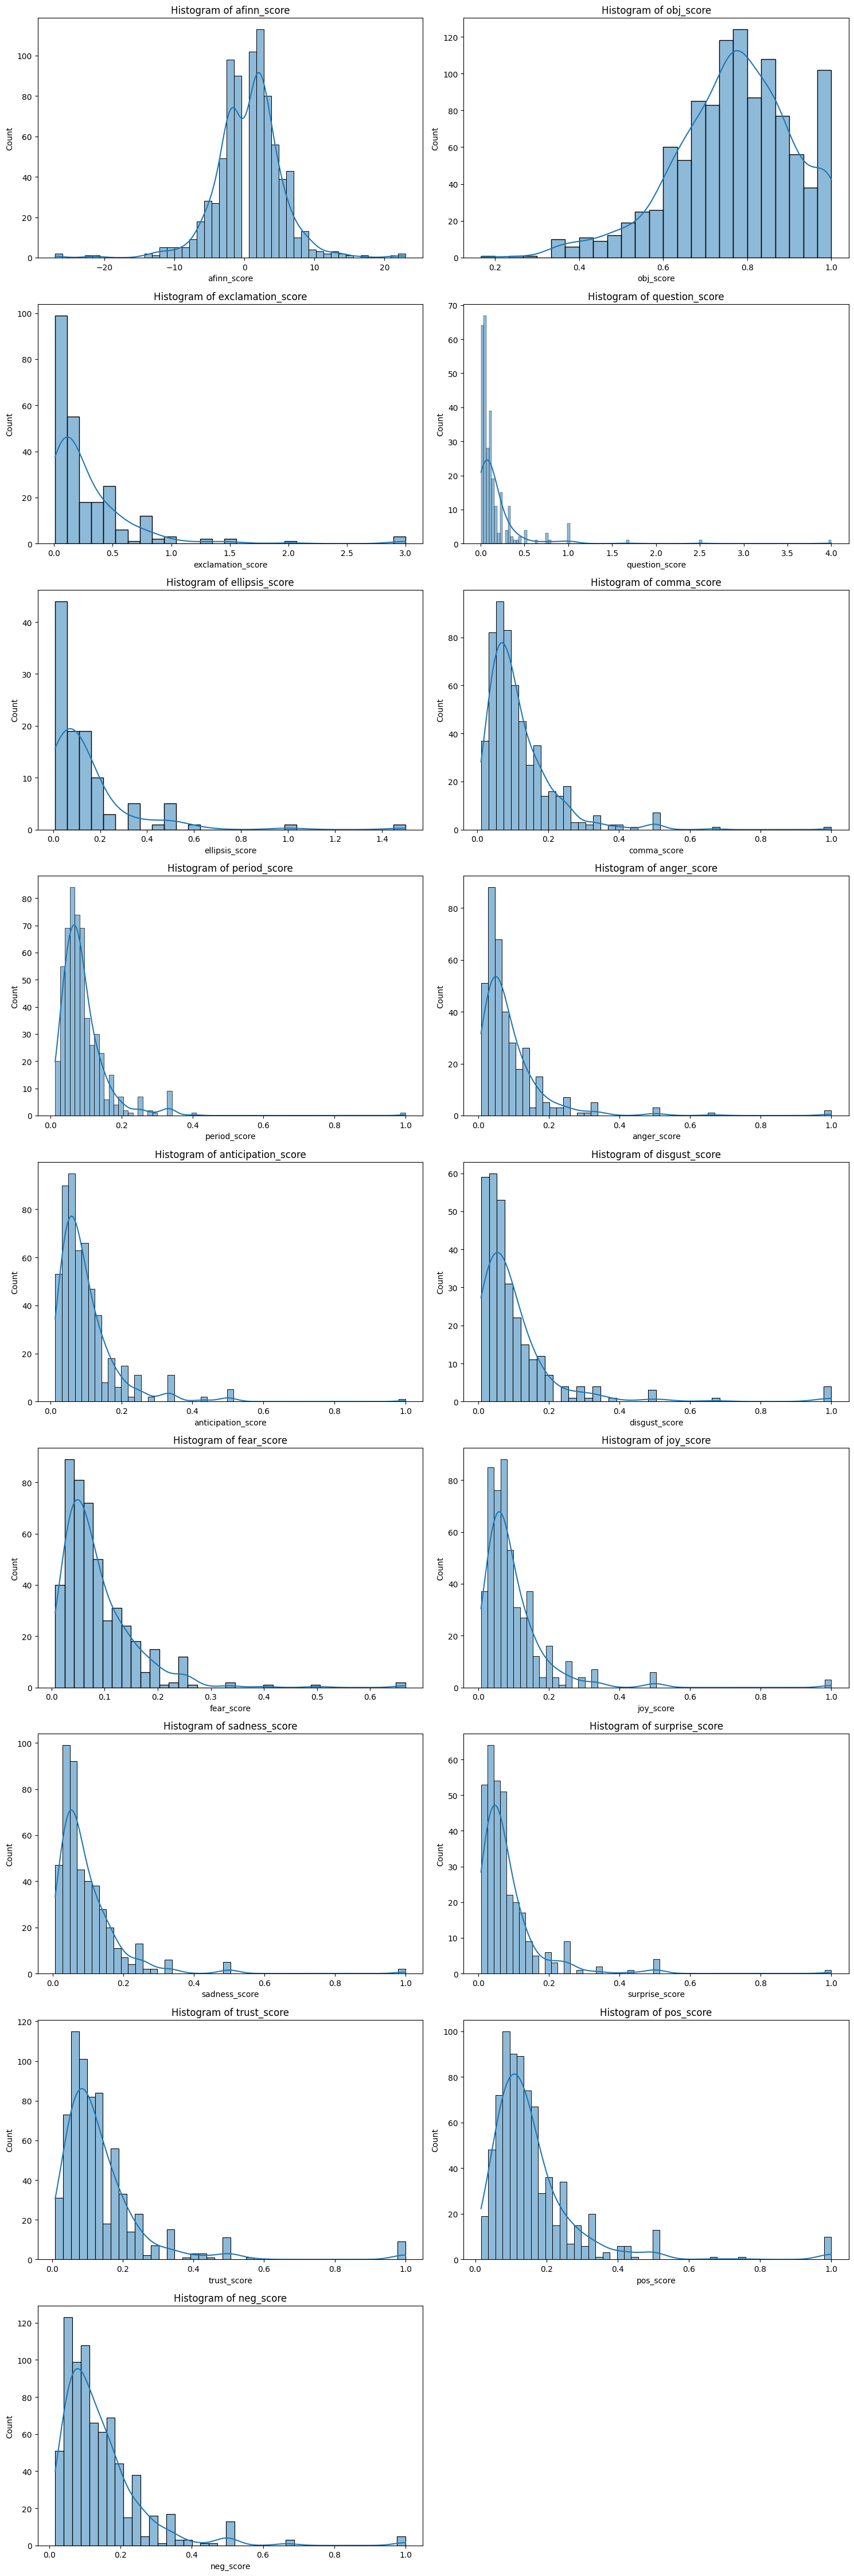

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

score_columns = [col for col in processed_data.columns if col.endswith('_score')]

# Step 2: Set up the grid layout
num_columns = 2  # Number of plots per row
num_plots = len(score_columns)
num_rows = (num_plots + num_columns - 1) // num_columns  # Calculate number of rows needed

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))

# Step 3: Plot each histogram
for i, col in enumerate(score_columns):
    row = i // num_columns
    col_index = i % num_columns
    non_zero_data = processed_data[col][processed_data[col] != 0]
    #use processed_data[col] instead of non_zero_data
    sns.histplot(non_zero_data, ax=axes[row, col_index], kde=True)
    axes[row, col_index].set_title(f'Histogram of {col}')

# If the number of plots is odd, remove the empty subplot
if num_plots % num_columns != 0:
    fig.delaxes(axes[num_rows-1, num_columns-1])

plt.tight_layout()
plt.show()

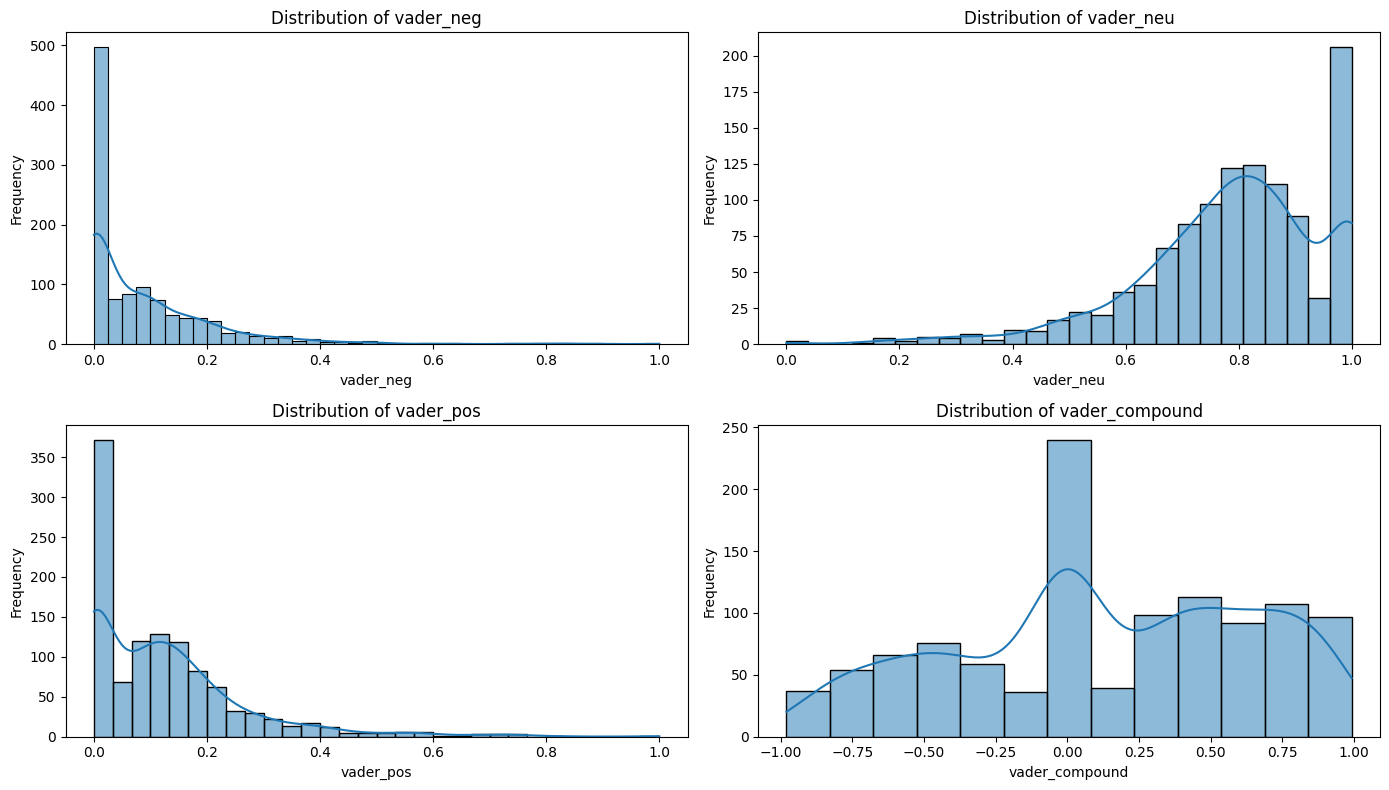

In [15]:
vader_columns = ['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']

# Set up the plot grid: 2 columns per row
num_cols = 2
num_rows = (len(vader_columns) + 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, num_rows * 4))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Plot histograms
for i, col in enumerate(vader_columns):
    sns.histplot(processed_data[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to avoid overlapping
plt.tight_layout()

# Show plot
plt.show()

In [16]:
print(processed_data.columns)

Index(['Text', 'Subjectivity', 'Sentiment Polarity', 'Emotion', 'Sarcasm',
       'Irony', 'Negation', 'Raw_Text', 'tokens', 'padded', 'masks',
       'exclamation_count', 'question_count', 'ellipsis_count', 'comma_count',
       'period_count', 'anger_count', 'anticipation_count', 'disgust_count',
       'fear_count', 'joy_count', 'sadness_count', 'surprise_count',
       'trust_count', 'pos_count', 'neg_count', 'afinn_score', 'obj_score',
       'exclamation_score', 'question_score', 'ellipsis_score', 'comma_score',
       'period_score', 'anger_score', 'anticipation_score', 'disgust_score',
       'fear_score', 'joy_score', 'sadness_score', 'surprise_score',
       'trust_score', 'pos_score', 'neg_score', 'vader_neg', 'vader_neu',
       'vader_pos', 'vader_compound'],
      dtype='object')


In [17]:
# score_columns = [col for col in processed_data.columns if col.endswith('_score')]
# for c in score_columns:
#     processed_data[c].describe()


score_columns = processed_data.filter(like='_score')

# Describe those columns
score_description = score_columns.describe()

score_description

/opt/homebrew/lib/python3.11/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/opt/homebrew/lib/python3.11/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/opt/homebrew/lib/python3.11/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


afinn_score    obj_score  exclamation_score  question_score  \
count  1114.000000  1114.000000        1110.000000     1111.000000   
mean      0.480251     0.765482           0.065042             inf   
std       4.061086     0.146449           0.231353             NaN   
min     -27.000000     0.000000           0.000000        0.000000   
25%      -1.000000     0.682853           0.000000        0.000000   
50%       0.000000     0.776179           0.000000        0.000000   
75%       2.000000     0.862370           0.000000        0.013333   
max      23.000000     1.000000           3.000000             inf   

       ellipsis_score  comma_score  period_score  anger_score  \
count          1111.0  1111.000000   1110.000000  1110.000000   
mean              inf          inf      0.044408     0.029339   
std               NaN          NaN      0.066789     0.072947   
min               0.0     0.000000      0.000000     0.000000   
25%               0.0     0.000000      0.000000     0.000000   
50%               0.0     0.000000      0.000000     0.000000   
75%               0.0     0.090909      0.075000     0.034844   
max               inf          inf      1.000000     1.000000   

       anticipation_score  disgust_score   fear_score    joy_score  \
count         1110.000000    1110.000000  1110.000000  1110.000000   
mean             0.047462       0.026556     0.036940     0.044619   
std              0.077696       0.083197     0.064104     0.085424   
min              0.000000       0.000000     0.000000     0.000000   
25%              0.000000       0.000000     0.000000     0.000000   
50%              0.000000       0.000000     0.000000     0.000000   
75%              0.071429       0.015040     0.055556     0.064516   
max              1.000000       1.000000     0.666667     1.000000   

       sadness_score  surprise_score  trust_score    pos_score    neg_score  
count    1110.000000     1110.000000  1110.000000  1110.000000  1110.000000  
mean        0.040269        0.023466     0.084784     0.110726     0.095025  
std         0.078844        0.062043     0.124870     0.135515     0.119073  
min         0.000000        0.000000     0.000000     0.000000     0.000000  
25%         0.000000        0.000000     0.000000     0.000000     0.000000  
50%         0.000000        0.000000     0.057418     0.090909     0.066667  
75%         0.055556        0.021681     0.122807     0.153846     0.142857  
max         1.000000        1.000000     1.000000     1.000000     1.000000

# New Features 


In [18]:
import pandas as pd
from collections import defaultdict

# Define the target emotions
emotions_of_interest = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']

# Paths to the lexicons (replace these paths with actual locations)
nrc_lexicon_path = '../Lexicons/NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'
affect_intensity_path = '../Lexicons/NRC-Emotion-Intensity-Lexicon/NRC-Emotion-Intensity-Lexicon-v1.txt'
vad_lexicon_path = '../Lexicons/NRC-VAD-Lexicon/NRC-VAD-Lexicon.txt'

# Load NRC Emotion Lexicon
nrc_lexicon = pd.read_csv(nrc_lexicon_path, sep='\t', header=None, names=['word', 'emotion', 'association'])
nrc_lexicon = nrc_lexicon[nrc_lexicon['emotion'].isin(emotions_of_interest) & nrc_lexicon['association'] == 1]

# Convert to dictionary
emotion_dict = defaultdict(lambda: {emotion: 0 for emotion in emotions_of_interest})
for _, row in nrc_lexicon.iterrows():
    word = row['word']
    emotion = row['emotion']
    emotion_dict[word][emotion] = 1  # Set the presence of the emotion for the word

# Load NRC Affect Intensity Lexicon (for anger, fear, joy, sadness)
affect_intensity_lexicon = pd.read_csv(affect_intensity_path, sep='\t', header=None, names=['word', 'emotion', 'intensity'])
affect_intensity_lexicon = affect_intensity_lexicon[affect_intensity_lexicon['emotion'].isin(['anger', 'fear', 'joy', 'sadness'])]

# Update emotion_dict with intensity scores
for _, row in affect_intensity_lexicon.iterrows():
    word = row['word']
    emotion = row['emotion']
    intensity = row['intensity']
    emotion_dict[word][emotion] = intensity  # Assign intensity scores

# Load NRC VAD Lexicon (Valence, Arousal, Dominance)
vad_lexicon = pd.read_csv(vad_lexicon_path, sep='\t', header=None, names=['word', 'valence', 'arousal', 'dominance'])

# Use VAD lexicon to estimate intensities for emotions like trust, anticipation, and surprise
# We need to map these VAD scores to the emotions we're interested in
def map_vad_to_emotions(valence, arousal, dominance):
    """
    Heuristic rules to map VAD scores to the remaining emotions:
    - Anticipation: High arousal, moderate dominance
    - Trust: High valence, high dominance
    - Surprise: High arousal, low dominance
    """
    emotions = {
        'anticipation': 0,
        'trust': 0,
        'surprise': 0
    }
    
    # Anticipation: Moderate to high arousal and dominance
    if arousal > 0.5 and dominance > 0.5:
        emotions['anticipation'] = (arousal + dominance) / 2
    
    # Trust: High valence and high dominance
    if valence > 0.6 and dominance > 0.6:
        emotions['trust'] = (valence + dominance) / 2
    
    # Surprise: High arousal and lower dominance
    if arousal > 0.7 and dominance < 0.5:
        emotions['surprise'] = arousal
    
    return emotions

# Update emotion_dict with VAD estimates
for _, row in vad_lexicon.iterrows():
    word = row['word']
    valence = row['valence']
    arousal = row['arousal']
    dominance = row['dominance']
    
    mapped_emotions = map_vad_to_emotions(valence, arousal, dominance)
    for emotion, intensity in mapped_emotions.items():
        if intensity > 0:
            emotion_dict[word][emotion] = intensity  # Assign mapped intensity score

# Now, emotion_dict contains all words with mapped emotions and intensities where available
print(f"Combined lexicon size: {len(emotion_dict)}")
print(emotion_dict)

Combined lexicon size: 10382
defaultdict(<function <lambda> at 0x105683560>, {'abacus': {'anger': 0, 'anticipation': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'sadness': 0, 'surprise': 0, 'trust': 1}, 'abandon': {'anger': 0, 'anticipation': 0, 'disgust': 0, 'fear': 0.531, 'joy': 0, 'sadness': 0.703, 'surprise': 0, 'trust': 0}, 'abandoned': {'anger': 0.222, 'anticipation': 0, 'disgust': 0, 'fear': 0.534, 'joy': 0, 'sadness': 0.828, 'surprise': 0, 'trust': 0}, 'abandonment': {'anger': 0.438, 'anticipation': 0, 'disgust': 0, 'fear': 0.609, 'joy': 0, 'sadness': 0.859, 'surprise': 1, 'trust': 0}, 'abbot': {'anger': 0, 'anticipation': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'sadness': 0, 'surprise': 0, 'trust': 1}, 'abduction': {'anger': 0, 'anticipation': 0.8315, 'disgust': 0, 'fear': 0.7, 'joy': 0, 'sadness': 0.75, 'surprise': 1, 'trust': 0}, 'aberration': {'anger': 0, 'anticipation': 0, 'disgust': 1, 'fear': 0, 'joy': 0, 'sadness': 0, 'surprise': 0.816, 'trust': 0}, 'abhor': {'anger': 0.816, 'a

In [19]:
def total_emotion_count(tokens, emotion_dict):
    emotions_count = {emotion: 0 for emotion in emotions_of_interest}
    
    for token in tokens:
        if token in emotion_dict:
            # Find the emotion with the highest score
            highest_emotion = max(emotion_dict[token], key=emotion_dict[token].get)
            emotions_count[highest_emotion] += 1  # Increment the count for the most dominant emotion
    
    return pd.Series(emotions_count)

# Example usage:
processed_data = processed_data.join(processed_data['tokens'].apply(lambda tokens: total_emotion_count(tokens, emotion_dict)).add_suffix('_tec'))


In [20]:
def total_emotion_intensity(tokens, emotion_dict):
    emotion_intensity = {emotion: 0.0 for emotion in emotions_of_interest}
    
    for token in tokens:
        if token in emotion_dict:
            for emotion, intensity in emotion_dict[token].items():
                emotion_intensity[emotion] += intensity  # Sum the intensity for each emotion
    
    return pd.Series(emotion_intensity)

# Example usage:
processed_data = processed_data.join(
    processed_data['tokens'].apply(lambda tokens: total_emotion_intensity(tokens, emotion_dict)).add_suffix('_tei')
)



In [21]:
def max_emotion_intensity(tokens, emotion_dict):
    max_intensity = {emotion: 0.0 for emotion in emotions_of_interest}
    
    for token in tokens:
        if token in emotion_dict:
            for emotion, intensity in emotion_dict[token].items():
                if intensity > max_intensity[emotion]:
                    max_intensity[emotion] = intensity  # Capture the highest intensity score
    
    return pd.Series(max_intensity)

# Example usage:
processed_data = processed_data.join(
    processed_data['tokens'].apply(lambda tokens: max_emotion_intensity(tokens, emotion_dict)).add_suffix('_mei')
)


In [22]:
def graded_emotion_count(tokens, emotion_dict, threshold=0.25):
    graded_count = {emotion: 0 for emotion in emotions_of_interest}
    
    for token in tokens:
        if token in emotion_dict:
            for emotion, intensity in emotion_dict[token].items():
                if intensity > threshold:
                    graded_count[emotion] += 1  # Count words with intensity over the threshold
    
    return pd.Series(graded_count)

# Example usage for different thresholds:
for threshold in [0.25, 0.5, 0.75]:
    processed_data = processed_data.join(
        processed_data['tokens'].apply(lambda tokens: graded_emotion_count(tokens, emotion_dict, threshold)).add_suffix(f'_gec_{threshold}')
    )


In [23]:
def graded_emotion_intensity(tokens, emotion_dict, threshold=0.25):
    graded_intensity = {emotion: 0.0 for emotion in emotions_of_interest}
    
    for token in tokens:
        if token in emotion_dict:
            for emotion, intensity in emotion_dict[token].items():
                if intensity > threshold:
                    graded_intensity[emotion] += intensity  # Sum intensity for words above the threshold
    
    return pd.Series(graded_intensity)

# Example usage for different thresholds
thresholds = [0.25, 0.5, 0.75]
for threshold in thresholds:
    processed_data = processed_data.join(
        processed_data['tokens'].apply(lambda tokens: graded_emotion_intensity(tokens, emotion_dict, threshold)).add_suffix(f'_gei_{threshold}')
    )

# Print new columns
new_columns = [col for col in processed_data.columns if col.endswith(tuple(f'_gei_{threshold}' for threshold in thresholds))]
print("New columns added:")
for col in new_columns:
    print(col)

New columns added:
anger_gei_0.25
anticipation_gei_0.25
disgust_gei_0.25
fear_gei_0.25
joy_gei_0.25
sadness_gei_0.25
surprise_gei_0.25
trust_gei_0.25
anger_gei_0.5
anticipation_gei_0.5
disgust_gei_0.5
fear_gei_0.5
joy_gei_0.5
sadness_gei_0.5
surprise_gei_0.5
trust_gei_0.5
anger_gei_0.75
anticipation_gei_0.75
disgust_gei_0.75
fear_gei_0.75
joy_gei_0.75
sadness_gei_0.75
surprise_gei_0.75
trust_gei_0.75


# Computational Approaches

In [24]:
#getting Polarity. 
from tqdm import tqdm
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

# Load sentiment analysis pipeline
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
sentiment_analyzer = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

def get_sentiment(tokens):
    total_score = 0
    result = sentiment_analyzer(tokens)
    if len(result) == 0:
        return 0.0
    for r in result:
        total_score += r['score']
    return total_score / len(result)

processed_data['polarity_score'] = processed_data['tokens'].apply(get_sentiment)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [25]:
#Subjectivity

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModelForSequenceClassification
import torch
import logging

loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
for logger in loggers:
    if "transformers" in logger.name.lower():
        logger.setLevel(logging.ERROR)

# Load BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("cffl/bert-base-styleclassification-subjective-neutral")
bert_model = BertModel.from_pretrained("cffl/bert-base-styleclassification-subjective-neutral")
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert_model = BertModel.from_pretrained('bert-base-uncased')

# Tokenize and convert to BERT embeddings
def get_bert_embeddings(texts):
    inputs = tokenizer(texts.tolist(), return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).numpy()

X = get_bert_embeddings(processed_data['Text'])
y = processed_data['Subjectivity']

# Train SVM classifier
clf = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True))
clf.fit(X, y)

# Get the decision function values or probabilities
subjectivity_probabilities = clf.predict_proba(X)

# Assuming binary classification, we take the probability of the positive class (index 1)
processed_data['subjectivity_score'] = subjectivity_probabilities[:, 1]

In [26]:
# Sarcasm detection using BERT and LSTM
import torch
import torch.nn as nn


class SarcasmLSTM(nn.Module):
    def __init__(self, bert_model, hidden_dim, output_dim, num_layers):
        super(SarcasmLSTM, self).__init__()
        self.bert = bert_model
        self.lstm = nn.LSTM(bert_model.config.hidden_size, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        with torch.no_grad():
            bert_output = self.bert(**inputs).last_hidden_state
        lstm_output, _ = self.lstm(bert_output)
        logits = self.fc(lstm_output[:, -1, :])
        return self.sigmoid(logits)

# Load BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("nikesh66/Sarcasm-Detection-using-BERT")
bert_model = BertModel.from_pretrained("nikesh66/Sarcasm-Detection-using-BERT")
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert_model = BertModel.from_pretrained('bert-base-uncased')

# Initialize the LSTM model
sarcasm_model = SarcasmLSTM(bert_model, hidden_dim=256, output_dim=1, num_layers=2)

# Tokenize and predict sarcasm for the entire dataset
inputs = tokenizer(processed_data['Text'].tolist(), return_tensors='pt', padding=True, truncation=True)
with torch.no_grad():
    sarcasm_prob = sarcasm_model(inputs).numpy()

processed_data['sarcasm_score'] = sarcasm_prob.flatten()  # Keep the raw probability

In [27]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
import pandas as pd

# Load the fine-tuned RoBERTa model and tokenizer for irony detection
tokenizer = AutoTokenizer.from_pretrained("vikram71198/roberta-base-finetuned-irony")
roberta_model = AutoModelForSequenceClassification.from_pretrained("vikram71198/roberta-base-finetuned-irony")

# Function to get predictions directly from the RoBERTa model
def detect_irony(texts):
    # Tokenize the input texts
    inputs = tokenizer(texts.tolist(), return_tensors='pt', padding=True, truncation=True)
    
    # Get model predictions
    with torch.no_grad():
        outputs = roberta_model(**inputs)
    
    # Convert logits to probabilities
    probabilities = torch.softmax(outputs.logits, dim=-1)
    
    # The model returns a probability for each class (ironic or not ironic)
    # Assuming binary classification (ironic vs. not ironic), we take the probability for the 'ironic' class
    irony_scores = probabilities[:, 1].numpy()  # Index 1 is usually for the positive class
    
    return irony_scores

# Assume processed_data is your DataFrame containing a 'Text' column
# Get irony_scores for each text in the DataFrame
processed_data['irony_score'] = detect_irony(processed_data['Text'])

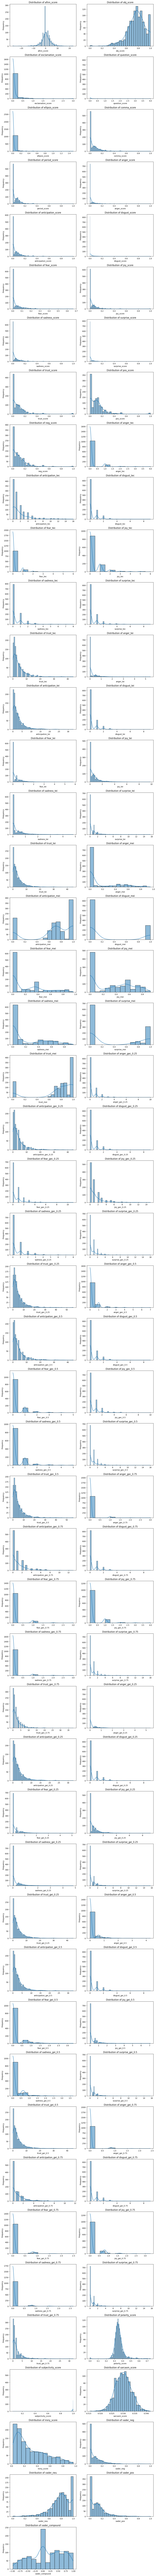

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# List of features to plot (using suffixes to include TEC, TEI, MEI, GEC, GEI)
feature_columns = [col for col in processed_data.columns if any(suffix in col for suffix in ['_tec', '_tei', '_mei', '_gec', '_gei','_score'])]
feature_columns = feature_columns + ['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']

# Determine number of rows needed (2 columns per row)
n_features = len(feature_columns)
n_rows = math.ceil(n_features / 2)

# Create subplots with 2 columns
fig, axes = plt.subplots(n_rows, 2, figsize=(12, n_rows * 4))

# Flatten axes array for easier iteration
axes = axes.flatten()

# Plot each feature's histogram in the grid
for i, feature in enumerate(feature_columns):
    sns.histplot(processed_data[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

# Remove unused subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

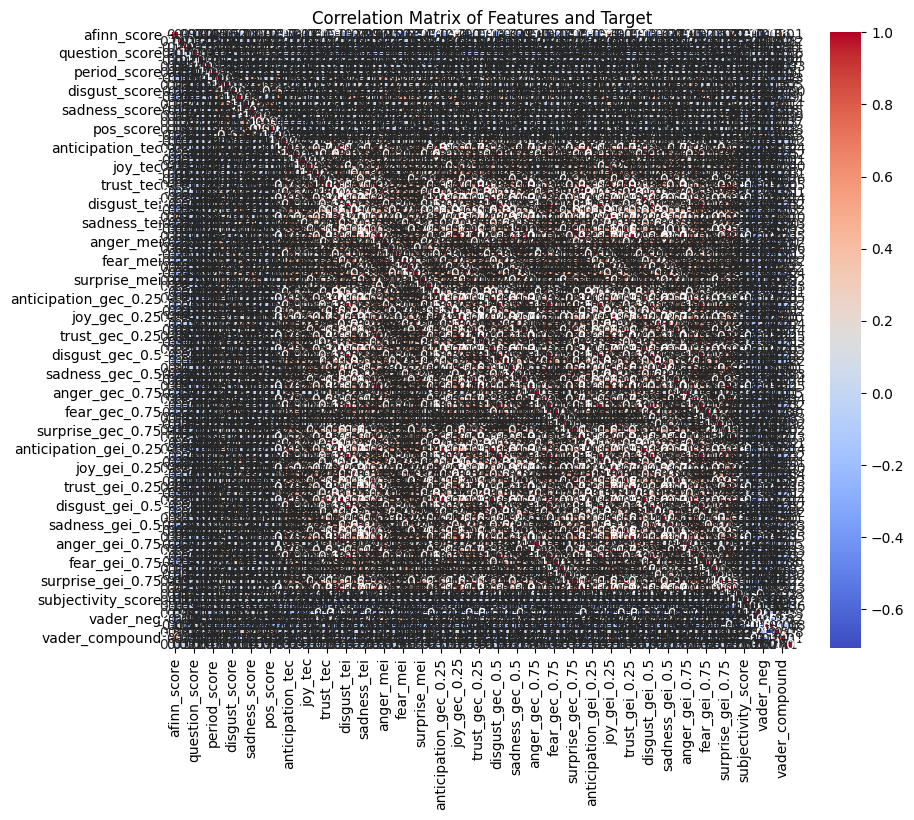

In [33]:
mapping_dict = {value: index for index, value in enumerate(processed_data['Emotion'].unique())}
processed_data['target'] = processed_data['Emotion'].map(mapping_dict)

correlation_data = processed_data[feature_columns + ['target']]

# Compute correlation matrix
correlation_matrix = correlation_data.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Features and Target')
plt.show()

In [ ]:
processed_data = processed_data.dropna()

In [40]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming 'target' is your dependent variable and the feature columns are independent variables
X = processed_data[feature_columns]
y = processed_data['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Logistic Regression
model = LogisticRegression(max_iter=2000)

# RFE for feature selection
rfe = RFE(estimator=model, n_features_to_select=7)  # You can change the number of features
rfe.fit(X_train, y_train)

# Print the selected features
selected_features = [feature for feature, rank in zip(feature_columns, rfe.ranking_) if rank == 1]
print("Selected Features: ", selected_features)

# Make predictions with selected features
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Fit and predict
model.fit(X_train_rfe, y_train)
y_pred = model.predict(X_test_rfe)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy with selected features: {accuracy}")

Selected Features:  ['obj_score', 'exclamation_score', 'question_score', 'joy_score', 'vader_neg', 'vader_neu', 'vader_pos']
Model accuracy with selected features: 0.27927927927927926


In [36]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming 'target' is your dependent variable and the feature columns are independent variables
X = processed_data[feature_columns]
y = processed_data['target']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize an SVM model with a linear kernel (suitable for RFE)
svm_model = SVC(kernel='linear')

# RFE for feature selection
rfe = RFE(estimator=svm_model, n_features_to_select=7)  # Select the top 5 features, adjust as needed
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = [feature for feature, rank in zip(feature_columns, rfe.ranking_) if rank == 1]
print("Selected Features: ", selected_features)

# Transform the train and test data to only use selected features
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Fit the SVM model on the selected features
svm_model.fit(X_train_rfe, y_train)

# Make predictions
y_pred = svm_model.predict(X_test_rfe)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy with selected features: {accuracy}")

Selected Features:  ['obj_score', 'exclamation_score', 'question_score', 'joy_score', 'vader_neg', 'vader_neu', 'vader_pos']
Model accuracy with selected features: 0.2747747747747748


In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming 'target' is your dependent variable and the feature columns are independent variables
X = processed_data[feature_columns]
y = processed_data['target']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a RandomForest model
rf_model = RandomForestClassifier(random_state=42)

# RFE for feature selection
rfe = RFE(estimator=rf_model, n_features_to_select=7)
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = [feature for feature, rank in zip(feature_columns, rfe.ranking_) if rank == 1]
print("Selected Features: ", selected_features)

# Transform the train and test data to only use selected features
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Fit the RandomForest model on the selected features
rf_model.fit(X_train_rfe, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_rfe)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy with selected features (RandomForest): {accuracy}")

Selected Features:  ['obj_score', 'trust_gei_0.5', 'polarity_score', 'subjectivity_score', 'sarcasm_score', 'irony_score', 'vader_neu']
Model accuracy with selected features (RandomForest): 0.21171171171171171


In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming 'target' is your dependent variable and the feature columns are independent variables
X = processed_data[feature_columns]
y = processed_data['target']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a DecisionTree model
dt_model = DecisionTreeClassifier(random_state=42)

# RFE for feature selection
rfe = RFE(estimator=dt_model, n_features_to_select=7)
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = [feature for feature, rank in zip(feature_columns, rfe.ranking_) if rank == 1]
print("Selected Features: ", selected_features)

# Transform the train and test data to only use selected features
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Fit the DecisionTree model on the selected features
dt_model.fit(X_train_rfe, y_train)

# Make predictions
y_pred = dt_model.predict(X_test_rfe)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy with selected features (DecisionTree): {accuracy}")

Selected Features:  ['obj_score', 'anticipation_tei', 'polarity_score', 'subjectivity_score', 'sarcasm_score', 'irony_score', 'vader_pos']
Model accuracy with selected features (DecisionTree): 0.24774774774774774


In [39]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming 'target' is your dependent variable and the feature columns are independent variables
X = processed_data[feature_columns]
y = processed_data['target']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a GradientBoosting model
gb_model = GradientBoostingClassifier(random_state=42)

# RFE for feature selection
rfe = RFE(estimator=gb_model, n_features_to_select=7)
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = [feature for feature, rank in zip(feature_columns, rfe.ranking_) if rank == 1]
print("Selected Features: ", selected_features)

# Transform the train and test data to only use selected features
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Fit the GradientBoosting model on the selected features
gb_model.fit(X_train_rfe, y_train)

# Make predictions
y_pred = gb_model.predict(X_test_rfe)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy with selected features (GradientBoosting): {accuracy}")

Selected Features:  ['obj_score', 'trust_gei_0.25', 'polarity_score', 'subjectivity_score', 'sarcasm_score', 'irony_score', 'vader_compound']
Model accuracy with selected features (GradientBoosting): 0.22972972972972974
